# Laboratory #07 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

# **Students** (First Name and Last Name)

1. Tatevik Davtyan
2. Eva Veli

---

In [ ]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import os
import numpy as np

from skimage.feature import ORB
from skimage.color import rgb2gray
from skimage.io import imread
from scipy.cluster.vq import vq
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from matplotlib import pyplot as plt


# Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment.
The subset of images is provided along with the notebook.
Upload the dataset to the drive and mount it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# modify the dataset variable with the path from your drive
dataset_path = '/content/drive/My Drive/CVLab_Images'


In [ ]:
categories = ['butterfly', 'kangaroo', 'dalmatian']

*   Create a list of file and the corresponding labels

In [ ]:
# solution
data = []
for category in categories:
    folder_path = os.path.join(dataset_path, category)
    for file in os.listdir(folder_path):
      file_path = os.path.join(folder_path, file)
      data.append((file_path, category))

In [ ]:
print('Total number of images:', len(data))

Total number of images: 244


*   Create a train / test split where the test is 10% of the total data

In [ ]:
# solution
paths, labels = zip(*data)
x_train, x_test, train_y, test_y= train_test_split(paths, labels, test_size=0.1, random_state=30)


In [ ]:
print('Train set:', len(x_train))
print('Test set:', len(x_test))

Train set: 219
Test set: 25


*   How do you select the train/test split?

**Solution**
There isn't any universal train/test split for every problem. In any case, we should use shuffle = True ( this is default) for splitting the data so that we are not biased towards certain classes when splitting.The most common ones are 80/20, 70/30 and 90/10 but the best train/test split percentage depends on the number of the data, the models running time etc.


# Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 64 keypoints.


In [ ]:
# solution
n = 64
descriptor_extractor = ORB(n_keypoints=n)

*   Extract ORB descriptors from all the images in the train set.


In [ ]:
# solution
def extract_descriptors(x_train,descriptor_extractor):
  descriptors = []
  for path in x_train:
    image = imread(path,as_gray = True)
    descriptor_extractor.detect_and_extract(image)
    descriptors.append(descriptor_extractor.descriptors)
  return descriptors
descriptors = extract_descriptors(x_train,descriptor_extractor)


*   What is the size of the feature descriptors? What does each dimension represent in the feature descriptors?

In [ ]:
# solution
print("train set size:", len(descriptors))
print("number of keypoints:", len(descriptors[0]))
print("descriptor's size:",len(descriptors[0][0]) )


train set size: 219
number of keypoints: 64
descriptor's size: 256


**Solution**

As you can see, we have 219 images, each image includes 64 peypoints because we directly mentioning in the implementation that ORB should find the best 64 keypoints, and for each keypoint we have 256 elements for the descriptor. In this case, the defaul is 256, which is obtained from sampling 256 pairwise intensity comparisons from 31x31 patch.

# Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use [sklearn.cluster.MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) for K-Means

In [ ]:
# solution
def get_all_desriptors(descriptors):
  all_descriptors = []
  for image in descriptors:
    for descriptor in image:
      all_descriptors.append(descriptor)
  return all_descriptors
def kMeans(all_descriptors):
  kmeans = MiniBatchKMeans(n_clusters=30, random_state=30,batch_size=6)
  kmeans = kmeans.partial_fit(all_descriptors)
  predictions = kmeans.predict(all_descriptors)
  return predictions,kmeans
all_descriptors = get_all_desriptors(descriptors)
predictions,kmeans = kMeans(all_descriptors)



*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.

In [ ]:
# solution
def create_histograms(descriptors,predictions):
  histograms = []
  for i in range(len(descriptors)):
    image = descriptors[i]
    image_predictions = predictions[i*n:n*(i+1)]
    histogram, _ = np.histogram(image_predictions, bins=np.arange(31))
    histograms.append(histogram)
  return histograms
histograms = create_histograms(descriptors,predictions)



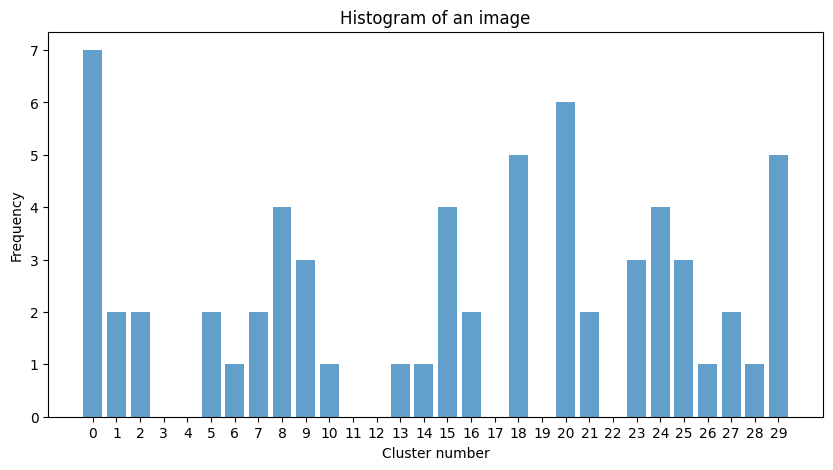

In [ ]:
# let's plot the histogram for one of the images
plt.figure(figsize=(10, 5))
plt.bar(range(30), histograms[0], align='center', alpha=0.7)
plt.title(f"Histogram of an image")
plt.xlabel("Cluster number")
plt.ylabel("Frequency")
plt.xticks(range(30))
plt.show()


# Creating Classification Model

*   The next step is to create a classification model. We will use a [C-Support Vector Classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for creating the model.



In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

*   Use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find the optimal value of C and Gamma.

In [ ]:
# solution
parameters = {'gamma':('scale', 'auto'), 'C':[1,3,5, 10]}
def grid_SVC(parameters,histograms,train_y):
  svc = SVC()
  clf = GridSearchCV(svc, parameters)
  clf.fit(histograms,train_y)
  return clf
clf = grid_SVC(parameters,histograms,train_y)



In [ ]:
clf.best_params_


{'C': 1, 'gamma': 'scale'}

In [ ]:
clf.best_score_

0.5706131078224101

As we can see, according to the GridSearch, the best parameters are 1 for C and 'gamma" for scale, which it found by using accuracy by default. Hence with the best model we get 0.57 accuracy on the train set.

# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


In [ ]:
# solution
best_model = clf.best_estimator_
descriptors = extract_descriptors(x_test,descriptor_extractor)
all_descriptors = get_all_desriptors(descriptors)
predictions = kmeans.predict(all_descriptors)
histograms = create_histograms(descriptors,predictions)
classification_prediction = best_model.predict(histograms)


*   Calculate the accuracy score for the classification model

In [ ]:
# solution
from sklearn.metrics import accuracy_score
print("Accuracy for the test set: ",accuracy_score(test_y,classification_prediction))


Accuracy for the test set:  0.56


*   Generate the confusion matrix for the classification model

In [ ]:
# solution
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y,classification_prediction)



array([[6, 2, 5],
       [0, 6, 1],
       [1, 2, 2]])

*   Why do we use Clustering to create the codebook?
*   What are the other techniques that can be used to create the codebook?

**Solution**

Since after ORB we have various keypoints, and they should be combined (cluster) to some groups where we except to have similar features so that later we can use thous different clusters for the histogram.
Although mostly clustering is used, other techniues for creating codebook include self-organising maps, additive kernel based,PCA based,Linde Buzo Gray etc.


...

# Increased Feature Dimensions

*   Repeat the classification using features of 256 ORB keypoints.

In [ ]:
# solution
n = 256
descriptor_extractor = ORB(n_keypoints=n)
descriptors = extract_descriptors(x_train,descriptor_extractor)
all_descriptors = get_all_desriptors(descriptors)
predictions,kmeans = kMeans(all_descriptors)
histograms = create_histograms(descriptors,predictions)
clf = grid_SVC(parameters,histograms,train_y)
print("Accuracy for the train set: ", clf.best_score_)

best_model = clf.best_estimator_
descriptors = extract_descriptors(x_test,descriptor_extractor)
all_descriptors = get_all_desriptors(descriptors)
predictions = kmeans.predict(all_descriptors)
histograms = create_histograms(descriptors,predictions)
classification_prediction = best_model.predict(histograms)
print("Accuracy for the test set: ",accuracy_score(test_y,classification_prediction))






Accuracy for the train set:  0.6025369978858351
Accuracy for the test set:  0.68


*   What is the difference in classifier performance between using 64 keypoints and 256 keypoints?

**Solution**

As we can see, the acuracy of both the train and test sets is increased when we obtain more keypoints. This means that the both the generalization and specialization is improved. We believe that the performance imrpoved because by having more keypoints in the image we get more information about the image and what it contains which helps the model to classifier easier.

...

*   Will further adding more keypoints increase the performance of the algorithm?

**Solution**
We believe that after certain number of keypoints, the performance will imrpove but increasing number of keypoints to a very large number can also result very big computational cost while the performance may not increase drastically after a certain point.


---

# **End of P7: Image Classification using Bag of Visual Words**

This notebook is part of **Deliverable 3**

Deadline for Deliverable 3 (P6 and P7) submission in CampusVirtual is: **Monday, the 18th of November, 2024**
